In [1]:
from typing import Union, Optional, Type, Any
from datetime import datetime, timedelta

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

from sklearn.linear_model import Ridge, lasso_path, RidgeCV


try:
    from functools import cached_property
except ImportError as error:
    if not error.msg.startswith("cannot import name 'cached_property' from 'functools'"):
        raise error
    # If we can't import the class, define it ourselves :)

    ################################################################################
    ### cached_property() - computed once per instance, cached as attribute
    ################################################################################

    _NOT_FOUND = object()
    class cached_property:
        def __init__(self, func):
            self.func = func
            self.attrname = None
            self.__doc__ = func.__doc__

        def __set_name__(self, owner, name):
            if self.attrname is None:
                self.attrname = name
            elif name != self.attrname:
                raise TypeError(
                    "Cannot assign the same cached_property to two different names "
                    f"({self.attrname!r} and {name!r})."
                )

        def __get__(self, instance, owner=None):
            if instance is None:
                return self
            if self.attrname is None:
                raise TypeError(
                    "Cannot use cached_property instance without calling __set_name__ on it.")
            try:
                cache = instance.__dict__
            except AttributeError:  # not all objects have __dict__ (e.g. class defines slots)
                msg = (
                    f"No '__dict__' attribute on {type(instance).__name__!r} "
                    f"instance to cache {self.attrname!r} property."
                )
                raise TypeError(msg) from None
            val = cache.get(self.attrname, _NOT_FOUND)
            if val is _NOT_FOUND:
                val = self.func(instance)
                try:
                    cache[self.attrname] = val
                except TypeError:
                    msg = (
                        f"The '__dict__' attribute on {type(instance).__name__!r} instance "
                        f"does not support item assignment for caching {self.attrname!r} property."
                    )
                    raise TypeError(msg) from None
            return val

In [2]:
tbg = pd.read_csv("./trends_by_income_groups.csv", index_col=0, parse_dates=["date"]).set_index("date")
print(tbg.index.min(), tbg.index.max())

2018-06-01 00:00:00 2021-05-10 00:00:00


In [3]:
COVID_factor = pd.read_csv("./covid_factor.csv", index_col=0, parse_dates=[0])
print(COVID_factor.index.min(), COVID_factor.index.max())

COVID_factor = pd.concat([
    COVID_factor,
    pd.DataFrame(
        np.ones(((COVID_factor.index.min() - tbg.index.min()).days, 1))*COVID_factor.iloc[0, 0],
        columns=COVID_factor.columns,
        index=pd.date_range(start=tbg.index.min(), end=COVID_factor.index.min(), freq="D", closed="left"),
    )
])
print(COVID_factor.index.min(), COVID_factor.index.max())
# Renormalizing
COVID_factor -= COVID_factor.mean()
COVID_factor /= COVID_factor.std()

2018-09-02 00:00:00 2021-05-10 00:00:00
2018-06-01 00:00:00 2021-05-10 00:00:00


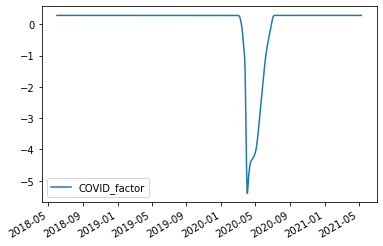

In [4]:
COVID_factor.plot()

In [5]:
new_year_dates = list(map(
    lambda x: x.strftime("%m-%d"),
    pd.date_range(start="2018-12-26", end="2019-01-09", freq="D", closed="left")
))
start = tbg.index.min()
end = tbg.index.max()
new_year_cleanup = np.zeros(((end-start).days+1, len(new_year_dates)))
for i, date in enumerate(new_year_dates):
    dts = [pd.to_datetime(f"{year}-{date}") for year in range(start.year, end.year+1)]
    filtered_num_dts = list(map(lambda x: (x-start).days, filter(lambda x: start <= x <= end, dts)))
    new_year_cleanup[filtered_num_dts, i] = 1
# Renormalizing
new_year_cleanup -= np.mean(new_year_cleanup, axis=0, dtype=np.float64, keepdims=True)
new_year_cleanup /= np.std(new_year_cleanup, axis=0, dtype=np.float64, keepdims=True)

In [10]:
class LinearProjection(object):
    def __init__(self, Y: np.ndarray, X: np.ndarray):
        self._X: np.ndarray = self.__format_inputs(X, "Features")
        self._Y: np.ndarray = self.__format_inputs(Y, "Targets")
        if self._Y.shape[0] != self._X.shape[0]:
            raise ValueError(
                "Shape mismatch: features have shape "
                + f"{self.X.shape} and targets have shape {self.Y.shape}"
            )
        self._N: int = self._X.shape[0]
        self._k: int = self._X.shape[1]
        self._t: int = self._Y.shape[1]


    @staticmethod
    def __format_inputs(Z: np.ndarray, name: Optional[str] = None) -> np.ndarray:
        if not isinstance(Z, np.ndarray):
            raise ValueError(f"{name} have type {type(Z)}, expected np.ndarray")
        if len(Z.shape) == 1:  # Replace with case-match when Py3.10 is delivered
            return Z.reshape((-1, 1)).astype(np.float64)
        elif len(Z.shape) == 2:
            return Z.astype(np.float64)
        else:
            raise ValueError(f"{name} have too many dimentions. Expected 1 or 2, got {len(Z.shape)}")

    @staticmethod
    def _dot(a: np.ndarray, b: np.ndarray) -> np.ndarray:
        return np.tensordot(a, b, axes=(1, 0))


    @cached_property
    def invExx(self) -> np.ndarray:
        return np.linalg.inv(self._dot(self._X.T, self._X) / self._N)

    @cached_property
    def beta_hat(self) -> np.ndarray:
        return self._dot(self.invExx, (self._dot(self._X.T, self._Y) / self._N))

    @cached_property
    def Y_hat(self) -> np.ndarray:
        return self._dot(self._X, self.beta_hat)

    @cached_property
    def e_hat(self) -> np.ndarray:
        return self._Y - self.Y_hat

    @cached_property
    def beta_error_cov(self) -> np.ndarray:
        """Layered error covariance matrixes [k, k, t]
        different layers for different targets
        """
        XeeX = np.mean(
            (
                np.expand_dims(self._X, axis=(2, 3))
                * np.expand_dims(self._X, axis=(1, 3))
                * np.square(np.expand_dims(self.e_hat, axis=(1, 2)))
            ), axis=0
        )
        return self._dot(self.invExx, self._dot(XeeX, self.invExx).swapaxes(1, 2)) / self._N

    @cached_property
    def beta_error_std(self) -> np.ndarray:
        return np.sqrt(self.beta_error_cov[(
            (np.arange(self._k).reshape((self._k, 1))*np.ones((1, self._t))).astype(int),
            (np.arange(self._k).reshape((self._k, 1))*np.ones((1, self._t))).astype(int),
            (np.arange(self._t).reshape((1, self._t))*np.ones((self._k, 1))).astype(int),
        )])

    @cached_property
    def beta_t_stat(self) -> np.ndarray:
        return self.beta_hat / np.sqrt(self.beta_error_std)

    @cached_property
    def beta_t_stat_p(self) -> np.ndarray:
        return stats.t.sf(np.abs(self.beta_t_stat), self._N) * 2

    @cached_property
    def r2(self) -> np.ndarray:
        return 1 - np.square(
            np.mean(np.square(self.e_hat), axis=0, dtype=np.float64)
            / np.std(self._Y, axis=0, dtype=np.float64)
        )

# lp = LinearProjection(
#     np.array([
#         [1, 1, 0],
#         [1, 2, 0],
#         [0, 3, -1],
#     ]),
#     np.array([
#         [1, 3],
#         [1, 4],
#         [1, 5],
#     ])
# )
# lp.invExx
# lp.beta_hat
# lp.Y_hat
# lp.e_hat
# lp.beta_error_cov[:, :, 0]
# lp.beta_t_stat_p
# lp.r2

                 status  corr.w.target  norm. test p-val
class    feature                                        
features 0         Auto       0.577656          0.948887
         1         Auto       0.428647          0.951836
         2         Auto      -0.015539          0.889784
         3           On       0.539508          0.735060
         4         Auto       0.576777          0.632004


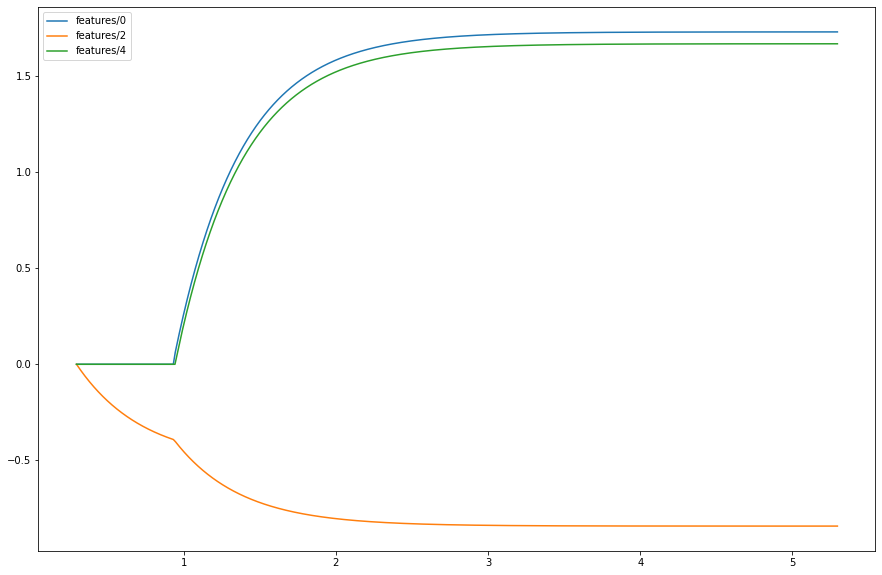

({'beta': array([ 0.97199338,  1.00191752, -1.95067849,  0.96583545]),
  'beta_error_cov': array([[ 0.00088207, -0.00019946, -0.00031122, -0.00025271],
         [-0.00019946,  0.00085359, -0.00032672, -0.00017645],
         [-0.00031122, -0.00032672,  0.00097875, -0.00023899],
         [-0.00025271, -0.00017645, -0.00023899,  0.00082742]]),
  'beta_error_std': array([0.02969959, 0.0292162 , 0.03128498, 0.02876499]),
  'beta_t_stat': array([ 4.29428686,  4.4629615 , -8.3969341 ,  4.33584778]),
  'R2': 0.9996006147803604},
 ['features/3', 'features/0', 'features/2', 'features/4'])

In [11]:
class LinearFeatureSelector(object):
    def __init__(self, targets, default_status: str = "Auto", plots: bool = True):
        self.targets: np.ndarray = np.asarray(targets).reshape((-1, 1))
        self.targets_mean: np.float64 = np.mean(self.targets, dtype=np.float64)
        self.targets_std: np.float64 = np.std(self.targets, dtype=np.float64)
        self.targets = (self.targets-self.targets_mean) / self.targets_std
        self.obs_count: int = self.targets.shape[0]
        
        self.features = list()  # The json, where the features are stored
        self.feature_index = dict()  # A dict for easy searching for a named feature class
        self.unnamed_group_count = 0  # A counter required to destinguish the unnamed features in the model
        
        if default_status in {"Auto", "On", "Off"}:
            self.default_status = default_status  # The default status for new features
        else:
            raise ValueError(
                f"Unsupported default status {default_status}. The supported "
                + "values are \"On\", \"Off\", and \"Auto\"."
            )
        
        self.plots = plots
        self.log = "Initialized the model\n"  # TODO: add some proper logging


    def __check_names_integrity(self):
        for feature_name, index in self.feature_index.items():
            assert self.features[index]["name"] == feature_name, "The feature index is inconsistent"
        for index, feature_cls in enumerate(self.features):
            assert self.feature_index[feature_cls["name"]] == index, "The feature index is inconsistent"
        for feature_cls in self.features:
            assert (
                len(feature_cls["features"])
                == len({feature["name"] for feature in feature_cls["features"]})
            ), "Feature class {0} has duplicate feature names".format(feature_cls.get("name", ""))

            
    def _check_integrity(self):
        self.__check_names_integrity()
        
    def _prepare_feature_cls_dict(self, name: str, **kwargs) -> dict:
        out = {
            "name": name,
        }
        out.update(kwargs)
        return out
    
    def _prepare_feature_dict(self, name: str, **kwargs) -> dict:
        out = {
            "name": name,
            "status": self.default_status,
        }
        out.update(kwargs)
        return out

    def _add_array_like_feature(self, feature: Union[np.ndarray, pd.Series, pd.DataFrame], cls_name=None):
        if cls_name is None:
            cls_name = f"external_feature_{self.unnamed_group_count}"
            self.unnamed_group_count += 1
        else:
            cls_name = str(cls_name)
            if cls_name in self.feature_index:
                raise ValueError(f"Feature class name {cls_name} is already taken.")
        
        class_core = self._prepare_feature_cls_dict(cls_name)
        # Checking feature's shape compatibility
        if len(feature.shape) > 2:
            raise ValueError(f"Input dimention mismatch. Got {len(feature.shape)} dimentions.")
        if feature.shape[0] != self.obs_count:
            raise ValueError(
                f"Input shape mismatch. Got {feature.shape} input "
                + f"for data with {self.obs_count} observations"
            )

        if isinstance(feature, np.ndarray):
            feature = feature.reshape((self.obs_count, -1))
            class_core["features"] = [
                self._prepare_feature_dict(
                    str(feature_num),
                    value=feature[:, feature_num].reshape((-1, 1)),
                )
                for feature_num in range(feature.shape[1])
            ]
        elif isinstance(feature, pd.Series):
            class_core["features"] = [
                self._prepare_feature_dict(
                    str(feature.name) if feature.name is not None else "0",
                    value=feature.values.reshape((-1, 1)),
                )
            ]
        elif isinstance(feature, pd.DataFrame):
            class_core["features"] = [
                self._prepare_feature_dict(
                    str(name) if name is not None else str(i),
                    value=feature.values[:, i].reshape((-1, 1)),
                )
                for i, name in enumerate(feature.columns)
            ]
        else:
            raise ValueError(
                f"Input type ({type(feature)}) is not recognized. "
                + "Expected one of [np.ndarray, pd.Series, pd.DataFrame]"
            )

        self.feature_index[cls_name] = len(self.features)
        self.features.append(class_core)        
        self._check_integrity()  # Debug run
        self.log += f"Added external feature {cls_name}\n"

    def add_features(self, *args, **kwargs) -> None:
        for arg in args:
            if isinstance(arg, (np.ndarray, pd.Series, pd.DataFrame)):
                self._add_array_like_feature(arg)
            elif isinstance(arg, (list, tuple, set)):
                for feature in arg:
                    if isinstance(feature, (np.ndarray, pd.Series, pd.DataFrame)):
                        self._add_array_like_feature(feature)
                    else:
                        raise ValueError(f"Input type is not recognized. Got <{type(arg)}>[{type(feature)}]")
            elif isinstance(arg, dict):
                for key, feature in arg.items():
                    if isinstance(feature, (np.ndarray, pd.Series, pd.DataFrame)) and isinstance(key, str):
                        self._add_array_like_feature(feature, cls_name=key)
                    else:
                        raise ValueError(f"Input type is not recognized. Got <dict>[{type(key)}: {type(feature)}]")
            else:
                raise ValueError(f"Input type is not recognized. Got {type(arg)}")
        for key, feature in kwargs.items():
            if isinstance(feature, (np.ndarray, pd.Series, pd.DataFrame)):
                self._add_array_like_feature(feature, cls_name=key)
            else:
                raise ValueError(f"Keyword argument type is not recognized. Got {type(feature)}")


    def _get_feature_stats(self, feature: dict, cls_meta: dict) -> dict:
        mean: np.float64 = np.mean(feature["value"], dtype=np.float64)
        std: np.float64 = np.std(feature["value"], dtype=np.float64)
        corr: np.float64 = np.mean(feature["value"]*self.targets, dtype=np.float64) / std
        m2: np.float64 = np.mean(np.square(feature["value"]), dtype=np.float64)
        m3: np.float64 = np.mean(np.power(feature["value"], 3), dtype=np.float64)
        m4: np.float64 = np.mean(np.power(feature["value"], 4), dtype=np.float64)
        test_err_matr = np.array([[m2 - (mean*mean), m3 - (mean*m2)], [m3 - (mean*m2), m4 - (m2*m2)]])
        test_vec = np.array([[mean], [m2-1]])
        test_stat = self.obs_count * test_vec.T.dot(np.linalg.inv(test_err_matr).dot(test_vec))[0, 0]
        test_pval = stats.chi2.sf(test_stat, 2)
        return {
            "status": feature["status"],
            "corr.w.target": corr,
            "norm. test p-val": test_pval,
        }

    def display_features(self):
        index, data = list(), list()
        for feature_cls in self.features:
            cls_meta = {k: v for k, v in feature_cls.items() if k != "features"}
            for feature in feature_cls["features"]:
                index.append((feature_cls["name"], feature["name"]))
                data.append(self._get_feature_stats(feature, cls_meta))
        return pd.DataFrame(data, index=pd.MultiIndex.from_tuples(index, names=["class", "feature"]))


    def _update_single_status(self, location, status: str) -> None:
        if status not in {"Auto", "On", "Off"}:
            raise ValueError(
                f"Unexpected status {status}. The expected values are \"On\", \"Off\", and \"Auto\"."
            )
        if isinstance(location, int):
            for feature in self.features[location]["features"]:
                feature["status"] = status
        elif isinstance(location, str):
            if location not in self.feature_index:
                raise ValueError(f"Feature class name {location} not found.")
            else:
                for feature in self.features[self.feature_index[location]]["features"]:
                    feature["status"] = status
        elif isinstance(location, (tuple, list)) and (len(location) == 2):
            cls_id, f_id = location
            if not (isinstance(cls_id, (int, str)) and isinstance(f_id, (int, str))):
                raise ValueError(f"location must be int, str or tuple[<int, str>, <int, str>]")
            if isinstance(cls_id, str):
                if cls_id not in self.feature_index:
                    raise ValueError(f"Feature class name {cls_id} not found.")
                else:
                    cls_id: int = self.feature_index[cls_id]
            if isinstance(f_id, str):
                id_name_dict = {f["name"]: i for i, f in enumerate(self.features[cls_id]["features"])}
                if f_id not in id_name_dict:
                    raise ValueError(f"Feature name {f_id} not found.")
                else:
                    f_id: int = id_name_dict[f_id]
            self.features[cls_id]["features"][f_id]["status"] = status
        else:
            raise ValueError(f"location must be int, str or tuple[<int, str>, <int, str>]")

    def update_status(self, locations: Union[list, tuple], statuses: Union[list, str]):
        if isinstance(locations, list) and isinstance(statuses, list):
            if len(locations) == len(statuses):
                for location, status in zip(locations, statuses):
                    self._update_single_status(location, status)
            else:
                raise ValueError(f"Lengths don't match: {len(locations)} != {len(statuses)}")
        elif isinstance(locations, list):
            for location in locations:
                self._update_single_status(location, statuses)
        else:
            self._update_single_status(locations, statuses)


    # Feature-selection section
    def _optimize_ridge_alpha(self, target: np.ndarray, features: np.ndarray) -> float:
        # TODO: push these parameters into some field
        adjustment_scale = (np.arange(21)-10).astype(np.float64)
        exp_sequence = np.array(
            [2.**(adjustment_scale.shape[0] ** (-i/2)) for i in range(15)]
        ).astype(np.float64)        
        alpha = 1.
        # This is a log-grid search for minimal leave-one-out variance
        # repeated several times with grid successively dencifying
        # around the most recent optimum candidate
        for e in exp_sequence:
            alphas = alpha * np.power(e, adjustment_scale)
            cv = (
                RidgeCV(alphas=alphas, fit_intercept=False, store_cv_values=True)
                .fit(features, target).cv_values_.sum(axis=0)
            )
            alpha = alphas[np.argmin(cv)]
        return alpha

    def _ridge_regression(self, target: np.ndarray, features: np.ndarray) -> np.ndarray:
        # Finding an optimal alpha for ridge regression
        alpha = self._optimize_ridge_alpha(target, features)
        # Running a ridge regression to get an efficient estimate of the coefficients
        return Ridge(alpha=alpha).fit(features, target).coef_.reshape(-1)

    def __lasso_plots(self, alphas: np.ndarray, coefs: np.ndarray, feature_names: list) -> None:
        plt.figure(figsize=(15, 10))
        # TODO: Fix the labeling
        for label, coef_l in zip(feature_names, coefs):
#         for label, coef_l in enumerate(coefs):
            if (coef_l != 0).sum() != 0:
                plt.plot(-np.log10(alphas), coef_l, label=label)
        plt.axis('tight')
        plt.legend()
        plt.show()

    def _lasso_regression(self, target: np.ndarray, features: np.ndarray, feature_names: list) -> np.ndarray:
        # TODO: push these parameters into some field
        eps, n_alphas = 1e-5, int(5e3)
        # Running the sequence of LASSO regressions
        alphas, coefs, _ = lasso_path(features, target[:, 0], eps=eps, n_alphas=n_alphas, fit_intercept=False)
        if self.plots:  # A nice picture of LASSO output  # (if requested)
            self.__lasso_plots(alphas, coefs, feature_names)
        return coefs

    @staticmethod
    def _mask_order_extractor(coefs: np.ndarray) -> list:
        # Extracting the unique combinations of regressors with non-zero coefficients
        bool_mask_list, bool_mask_set = list(), set()
        for lane in coefs.T:
            bool_mask = tuple(lane != 0)
            if any(bool_mask) and (bool_mask not in bool_mask_set):
                bool_mask_set.add(bool_mask)
                bool_mask_list.append(list(bool_mask))
        return bool_mask_list

    def _ordered_feature_selection(self, target: np.ndarray, features: np.ndarray, mask_list: list) -> tuple:
        # Checking the unique combinations of regressors using leave-one-out OLS
        self.selection_log = [None] * len(mask_list)
        for i, bool_mask in enumerate(mask_list):
            considered_cv = (  # Not sure why fit_intercept was true when I started refactoring....
                RidgeCV(alphas=np.array([1e-100]), store_cv_values=True, fit_intercept=False)
                .fit(features[:, bool_mask], target)
                .cv_values_[:, 0]
            )
            self.selection_log[i] = {
                "mask": bool_mask,
                "cv_MSE": considered_cv.mean(),
            }  # Custom selection metrics can be employed, but for OLS there is no point
        min_cv, best_idx = float("inf"), None
        for i in range(len(mask_list)):
            if self.selection_log[i]["cv_MSE"] < min_cv:
                min_cv = self.selection_log[i]["cv_MSE"]
                best_mask = self.selection_log[i]["mask"]
        return best_mask

    def select_via_adaptive_lasso(
            self, target: np.ndarray, features: np.ndarray,
            feature_names: Optional[list] = None
    ) -> tuple:
        """Adaptive LASSO to select the features"""
        # Filling the default values into feature_names
        if feature_names is None:
            feature_names = list(map(str, range(features.shape[1])))
        # Checking consistency of feature_names' list
        if len(feature_names) != features.shape[1]:
            raise ValueEerror(
                "Feature names' list length mismatch: "
                + f"got {len(feature_names)} names for {features.shape[1]} features"
            )
        # Initial estimator for lasso adaption
        initial_estimator = self._ridge_regression(target, features)
        # Modifying the features to switch LASSO into adaptive mode
        adapted_features = features * np.power(initial_estimator, 2.)  # TODO: push this parameter into some field
        # Running adaptive LASSO and extracting the coefficient consideration order
        mask_list = self._mask_order_extractor(self._lasso_regression(target, adapted_features, feature_names))
        # Checking the unique combinations of regressors using leave-one-out OLS
        return self._ordered_feature_selection(target, features, mask_list)

    def _extract_indexes_for_selection(self) -> tuple:
        on_index, auto_index = list(), list()
        for cls_idx, feature_cls in enumerate(self.features):
            for f_idx, feature in enumerate(feature_cls["features"]):
                if feature["status"] == "On":
                    on_index.append((cls_idx, f_idx))
                elif feature["status"] == "Auto":
                    auto_index.append((cls_idx, f_idx))
        if (not on_index) and (not auto_index):
            raise VaueError("No features selected for selection")
        return on_index, auto_index
    
    def _extract_names_from_index(self, index: list) -> list:
        return [
            "{cls}/{feature}".format(
                cls=self.features[idx[0]]["name"],
                feature=self.features[idx[0]]["features"][idx[1]]["name"],
            )
            for idx in index
        ]

    def _remove_the_preselected_features(self, on_index: list, auto_index: list) -> tuple:
        auto_features = np.hstack([
            self.features[idx[0]]["features"][idx[1]]["value"]
            for idx in auto_index
        ])
        if not on_index:
            return self.targets.copy(), auto_features
        on_features = np.hstack([
            self.features[idx[0]]["features"][idx[1]]["value"]
            for idx in on_index
        ])
        target_residuals = LinearProjection(self.targets, on_features).e_hat
        auto_residuals = LinearProjection(auto_features, on_features).e_hat
        return target_residuals, auto_residuals
    
    def _regress_on_selected_features(self, selected_index: list) -> dict:
        features = np.hstack([
            self.features[idx[0]]["features"][idx[1]]["value"]
            for idx in selected_index
        ])
        reg_on_selected = LinearProjection(self.targets, features)
        return {
            "beta": reg_on_selected.beta_hat[:, 0] * self.targets_std,
            "beta_error_cov": reg_on_selected.beta_error_cov[:, :, 0] * (self.targets_std**2),
            "beta_error_std": reg_on_selected.beta_error_std[:, 0] * self.targets_std,
            "beta_t_stat": reg_on_selected.beta_t_stat[:, 0],
            "R2": reg_on_selected.r2[0],
        }

    def select_features(self):
        # Extracting the features to use in the selection
        on_index, auto_index = self._extract_indexes_for_selection()
        # FWL-removal of the forcedly-included features
        target_mod, fearues_mod = self._remove_the_preselected_features(on_index, auto_index)
        # Selecting the features from the modified set (and modified targets)
        auto_names = self._extract_names_from_index(auto_index)
        auto_mask = self.select_via_adaptive_lasso(target_mod, fearues_mod, auto_names)
        # Compressing the indexes of selected features into one
        selected_index = on_index + [idx for i, idx in enumerate(auto_index) if auto_mask[i]]
        return self._regress_on_selected_features(selected_index), self._extract_names_from_index(selected_index)


# Testing section
np.random.seed(9001)
rho = 0.3
N, k = 150, 5
X = np.random.normal(0, 1, (N, k))
X = X.dot(np.ones((k, k))*rho + np.eye(k)*(1-rho))
X /= np.std(X, axis=0, keepdims=True)
beta = np.array([[1], [0], [-2], [1], [1]])
y = np.dot(X, beta)




selecting_test = LinearFeatureSelector(y)
selecting_test.add_features(features=X)
selecting_test.update_status(("features", "3"), "On")
print(selecting_test.display_features())
selecting_test.select_features()

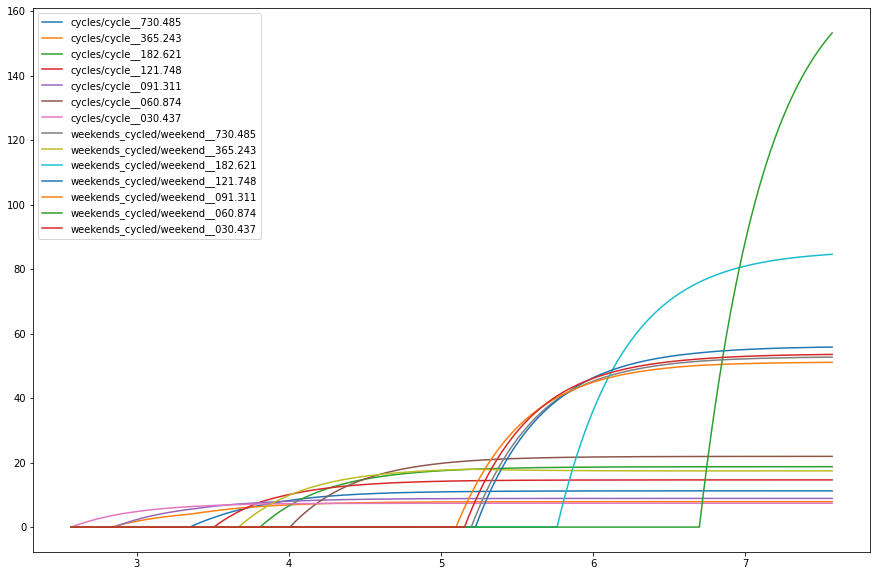

({'beta': array([ 0.13962863,  0.00780113,  0.01013887,  0.01595212,  0.0517477 ,
         -0.04872624, -0.13816142, -0.01814154,  0.01714261,  0.019448  ,
          0.02365821,  0.02787504,  0.03542797,  0.00627079, -0.05930731,
         -0.03515561, -0.02601116, -0.0254282 , -0.01798323, -0.01893709,
         -0.03742095, -0.02734075, -0.02142429, -0.01434913, -0.03416427,
         -0.01222392, -0.00487107,  0.01395902, -0.01058103, -0.01615477,
         -0.03014918,  0.00874948, -0.01237906,  0.00236039,  0.01401817,
         -0.03482463, -0.00045136, -0.00527767, -0.00159905,  0.01575062,
          0.00102259, -0.00479341, -0.00524449, -0.0013873 , -0.00349025,
          0.00383286]),
  'beta_t_stat': array([ 4.6107236 ,  0.21594496,  0.28547523,  0.4498595 ,  1.44399369,
         -1.38226575, -4.01581285, -0.50886175,  0.80483092,  0.72212893,
          0.89354508,  0.85888712,  1.72742732,  0.1655446 , -1.55119839,
         -1.0232161 , -0.56998201, -0.81237482, -0.6903322 , -0.6

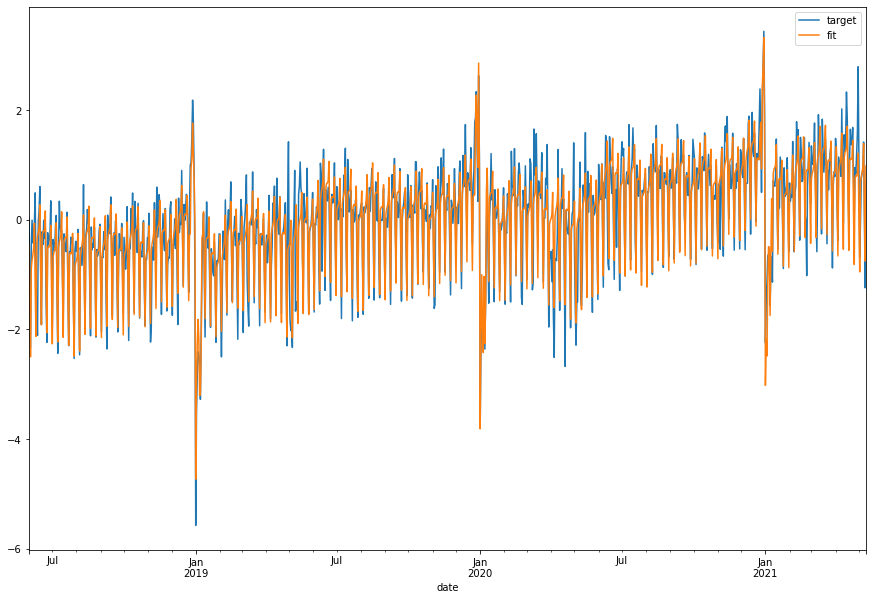

In [12]:
class SeasonalityExtractor(LinearFeatureSelector):
    def __init__(
            self, targets, dts, default_status: str = "Auto",
            start_dt=pd.to_datetime("2018-01-01"), scale=None, periods: Optional[list] = None,
            plots: bool = True,
    ):
        super().__init__(targets, default_status, plots)

        if periods is None:
            periods = [365.2425 / i for i in [.5, 1, 2, 3, 4, 6, 12]]
        self.periods = periods
        if scale is None:
            scale = np.timedelta64(24 * 3600, "s")
        
        self.dts = dts
        self.diffs = np.asarray((dts - start_dt) / scale).reshape((-1, 1))
        assert np.all(self.diffs == np.round(self.diffs, decimals=0)), "The scaling does not provide round values"
        assert self.diffs.shape[0] == self.obs_count, "Input shape mismatch"
        
        self._add_trend()
        self._add_cycles()
        self._add_weekdays(0)  # Dropping Sundays
        self._add_weekends()

    def _prepare_feature_cls_dict(self, name: str, **kwargs) -> dict:
        out = {"cyclical": False}
        out.update(super()._prepare_feature_cls_dict(name, **kwargs))
        return out

    def cyclify_feature(self, feature_cls: Union[int, str], status: Optional[str] = "Off"):
        if status not in {"Off", "On", "Auto", None}:
            raise ValueError(f"Status {status} is not supported")
        # Processing the string and indeger indexing
        if isinstance(feature_cls, int):
            old_feature_idx = feature_cls
            feature_cls = self.features[feature_cls]["name"]
        elif isinstance(feature_cls, str):
            old_feature_idx = self.feature_index.get(feature_cls, None)
        else:
             raise ValueError(f"Expcted feature_cls to be str or int, got {type(feature_cls)}")
        # Checking that the feature to cyclify exists. And that it is not cyclified yet
        if old_feature_idx is None:
            raise ValueError(f"Feature {feature_cls} not found")
        else:  # If the original class is found, get features
            old_features = self.features[old_feature_idx]["features"]
        if (f"{feature_cls}_cycled" in self.feature_index) or (self.features[old_feature_idx]["cyclical"]):
            raise ValueError(f"Feature {feature_cls} is cyclified")
        # Making the class for the new features
        new_cls = self._prepare_feature_cls_dict(f"{feature_cls}_cycled", cyclical=True)
        # Filling the class with features
        new_cls["features"] = list()
        for feature in old_features:
            value = feature["value"]
            feature_status = feature["status"] if status is None else status
            for period in self.periods:
                new_cls["features"].append(
                    self._prepare_feature_dict(
                        feature["name"] + f"__{period:07.3f}",
                        status=feature_status,
                        sin_cos=[
                            value * np.sin((self.diffs * (2*np.pi)) / period) / (.5**.5),
                            value * np.cos((self.diffs * (2*np.pi)) / period) / (.5**.5),
                        ],
                    )
                )
        # Adding the feature class, and modifying the index
        self.feature_index[new_cls["name"]] = len(self.features)
        self.features.append(new_cls)
        self._check_integrity()  # Debug run
        self.log += "Added {0}\n".format(new_cls["name"])

    def _add_trend(self):
        if "trend" in self.feature_index:
            raise ValueError("Trend is already added to the model")
        self.features.append(
            self._prepare_feature_cls_dict(
                "trend",
                features=[
                    self._prepare_feature_dict(
                        "linear",
                        value=(
                            (self.diffs - np.mean(self.diffs, dtype=np.float64))
                            / np.std(self.diffs, dtype=np.float64)
                        ),
                    )
                ],
            )
        )
        self.feature_index["trend"] = len(self.features) - 1
        self._check_integrity()  # Debug run
        self.log += "Added trend\n"

    @staticmethod
    def __extract_weekdays(days_to_skip=None):
        weekdays = list(range(7))
        if days_to_skip is not None:
            if isinstance(days_to_skip, int):
                weekdays = [wd for wd in weekdays if wd != days_to_skip]
            elif isinstance(days_to_skip, (list, tuple, set, dict, np.array)):
                weekdays = [wd for wd in weekdays if wd not in days_to_skip]
            else:
                raise ValueError(f"days_to_skip has unrecognised type {type(days_to_skip)}")
        return weekdays

    def _add_weekdays(self, days_to_skip=None):
        if "weekdays" in self.feature_index:
            raise ValueError("Weekdays are already added to the model")
        status = "Off" if "weekends" in self.feature_index else self.default_status
        self.features.append(
            self._prepare_feature_cls_dict(
                "weekdays",
                linearly_dependent=(days_to_skip is None),
                features=[
                    self._prepare_feature_dict(
                        f"weekday_{wd}",
                        status=status,
                        value=((self.diffs.astype(int)%7 == wd) - (1./7.))/(6.**.5 / 7.),
                    )
                    for wd in self.__extract_weekdays(days_to_skip)
                ],
            )
        )
        self.feature_index["weekdays"] = len(self.features) - 1
        self._check_integrity()  # Debug run
        self.log += "Added weekdays\n"

    def _add_weekends(self):
        if "weekends" in self.feature_index:
            raise ValueError("Weekends are already added to the model")
        status = "Off" if "weekdays" in self.feature_index else self.default_status
        self.features.append(
            self._prepare_feature_cls_dict(
                "weekends",
                features=[
                    self._prepare_feature_dict(
                        "weekend",
                        status=status,
                        value=((self.diffs.astype(int)%7 >= 5) - (2./7.))/(10.**.5 / 7.),
                    )
                ],
            )
        )
        self.feature_index["weekends"] = len(self.features) - 1
        self._check_integrity()  # Debug run:
        self.log += "Added weekends\n"

    def _add_cycles(self):
        if "cycles" in self.feature_index:
            raise ValueError("Main cycles are already added to the model")
        self.features.append(
            self._prepare_feature_cls_dict(
                "cycles",
                cyclical=True,
                features=[
                    self._prepare_feature_dict(
                        f"cycle__{period:07.3f}",
                        sin_cos=[
                            np.sin((self.diffs * (2*np.pi)) / period) / (.5**.5),
                            np.cos((self.diffs * (2*np.pi)) / period) / (.5**.5),
                        ],
                    )
                    for period in self.periods
                ],
            )
        )
        self.feature_index["cycles"] = len(self.features) - 1
        self._check_integrity()  # Debug run
        self.log += "Added main cycles"+ " ".join(map(str, self.periods)) + "\n"


    @staticmethod
    def _phase_extractor(coefs: np.ndarray) -> np.ndarray:
        count, residual = divmod(coefs.size, 2)
        if residual:
            raise ValueError(f"Odd number of coefficients, even is expexted.")

        out = np.empty((count,), dtype=np.float64)
        for i in range(count):
            c_sin_cos = coefs[[2*i, (2*i) + 1]]
            c_sin_cos = c_sin_cos / np.sqrt(np.sum(np.square(c_sin_cos)))  # Rescaling the coefs
            out[i] = np.arccos(c_sin_cos[0]) * (c_sin_cos[1]/abs(c_sin_cos[1]))  # Coef b4 sin is a cos
        return out

    @staticmethod
    def _cycle_collapser(features: np.ndarray, phases: np.ndarray) -> np.ndarray:
        if len(features.shape) != 2:
            raise ValueError(f"features has {len(features.shape)} dimentions - expected 2.")
        count, residual = divmod(features.shape[1], 2)
        if residual:
            raise ValueError(f"Odd number of features, even is expexted.")
        if len(phases.shape) != 1:
            raise ValueError(f"phases has {len(phases.shape)} dimentions - expected 1.")
        if features.shape[1] != phases.shape[0]*2:
            raise ValueError(
                "Shape mismatch: features and phases have shapes "
                + f"{features.shape} and {phases.shape} respectively"
            )

        coefs = np.vstack([np.cos(phases.reshape((1, -1))), np.sin(phases.reshape((1, -1)))])
        out = np.empty((features.shape[0], count), dtype=np.float64)
        for i in range(count):
            out[:, i] = features[:, [2*i, (2*i) + 1]].dot(coefs[:, i])
        return out

    def _remove_the_preselected_features(self, on_index: list, auto_index: list) -> tuple:
        if not auto_index:
            raise ValueError("Need at least one feature to select among.")

        __sentinel_array = [np.ones((self.obs_count, 0))]
        
        F_cycled_auto = np.hstack(sum([
            self.features[idx[0]]["features"][idx[1]]["sin_cos"]
            for idx in auto_index if self.features[idx[0]]["cyclical"]
        ], __sentinel_array))
        F_linear_auto = np.hstack([
            self.features[idx[0]]["features"][idx[1]]["value"]
            for idx in auto_index if not self.features[idx[0]]["cyclical"]
        ] + __sentinel_array)
        
        targets = self.targets
        if on_index:  # Removing the variance already explained
            F_cycled_on = np.hstack(sum([
                self.features[idx[0]]["features"][idx[1]]["sin_cos"]
                for idx in on_index if self.features[idx[0]]["cyclical"]
            ], __sentinel_array))
            if F_cycled_on.size:  # Removing from non-cyclical auto_ features
                F_linear_auto = LinearProjection(F_linear_auto, F_cycled_on).e_hat
#                 F_cycled_auto = LinearProjection(F_cycled_auto, F_cycled_on).e_hat
                targets = LinearProjection(targets, F_cycled_on).e_hat
            del F_cycled_on

            F_linear_on = np.hstack([
                self.features[idx[0]]["features"][idx[1]]["value"]
                for idx in on_index if not self.features[idx[0]]["cyclical"]
            ] + __sentinel_array)
            if F_linear_on.size:  # Removing from all auto_ features
                F_linear_auto = LinearProjection(F_linear_auto, F_linear_on).e_hat
                F_cycled_auto = LinearProjection(F_cycled_auto, F_linear_on).e_hat
                targets = LinearProjection(targets, F_linear_on).e_hat
            del F_linear_on

        # Ridge to determine phases of the auto_ features
        auto_ridge_coefs = self._ridge_regression(
            targets,
            np.hstack([F_linear_auto, F_cycled_auto]),
        )
        auto_phases = self._phase_extractor(auto_ridge_coefs[F_linear_auto.shape[1]:])
        F_cycled_auto_collapsed = self._cycle_collapser(F_cycled_auto, auto_phases)

        # Using 2 iterators to appropriately order linear and cycled features
        lin, cyc = iter(range(F_linear_auto.shape[1])), iter(range(F_cycled_auto.shape[1] // 2))
        auto_features = np.hstack([
            (  # taking the next cycled feature if it is requred or the next linear feature otherwise
                F_cycled_auto_collapsed[:, next(cyc)].reshape((-1, 1))
                if self.features[idx[0]]["cyclical"]
                else F_linear_auto[:, next(lin)].reshape((-1, 1))
            ) for idx in auto_index
        ])
        return targets, auto_features

    def _regress_on_selected_features(self, selected_index: list) -> dict:
        features = np.hstack(sum([
            (
                self.features[idx[0]]["features"][idx[1]]["sin_cos"]
                if self.features[idx[0]]["cyclical"]
                else [self.features[idx[0]]["features"][idx[1]]["value"],]
            ) for idx in selected_index
        ], []))
        reg_on_selected = LinearProjection(self.targets, features)
    
        if self.plots:
            pd.DataFrame(
                np.hstack([self.targets, reg_on_selected.Y_hat]),
                index=self.dts,
                columns=["target", "fit"]
            ).plot(figsize=(15, 10))
        return {
            "beta": reg_on_selected.beta_hat[:, 0] * self.targets_std,
#             "beta_error_cov": reg_on_selected.beta_error_cov[:, :, 0] * (self.targets_std**2),
#             "beta_error_std": reg_on_selected.beta_error_std[:, 0] * self.targets_std,
            "beta_t_stat": reg_on_selected.beta_t_stat[:, 0],
            "R2": reg_on_selected.r2[0],
        }


trial_thing = tbg[tbg["group"] == 90]["0"]    

SE = SeasonalityExtractor(np.log(trial_thing.values), trial_thing.index)#, plots=False)
SE.cyclify_feature("weekends", "Auto")
SE.add_features(covid=COVID_factor, new_year=new_year_cleanup)
SE.update_status(("trend"), "On")
SE.update_status(("weekends"), "Off")
SE.update_status(("weekdays"), "On")
SE.update_status(("covid"), "On")
# SE.update_status(("covid"), "Auto")
SE.update_status(("new_year"), "On")
# SE.update_status(("new_year"), "Auto")

# SE.update_status(("weekends_cycled"), "Off")
# SE.update_status(("weekends_cycled", 5), "On")
# print(SE.display_features())
SE.select_features()

In [13]:
# A function for factor-generation for a day
class factor_generator(object):
    def __init__(self, input_type: Type = int, default_input: Optional[Any] = None):
        self.features: list = []  # JSON: [{"name":str, "formula":callable, "meta": dict}]
        self.__unnamed_features_count: int = 0
        self._input_type: Type = input_type
        if default_input is None:
            self._default_input = [self._input_type(0)]
        else:
            self._default_input = [self._input_type(default_input)]

    def __call__(self, input_array) -> list:
        if not isinstance(input_array, list):
            input_array = [self._input_type(input_array)]
        return [sum(f_list, []) for f_list in zip(*self._get_features(input_array))]

    def _get_features(self, in_array: list) -> list:
        out = [None] * len(self.features)
        for num, feature in enumerate(self.features):
            next_feature = self._feature_call(feature["formula"], in_array)
            if not isinstance(next_feature, list):
                raise ValueError("Feature {0} returned type {1}, expected list.".format(
                    feature["name"], type(next_feature),
                ))
            if len(next_feature) != len(in_array):
                raise ValueError("Length mismatch: feature {0} has length {1}, expected {2}.".format(
                    feature["name"], len(next_feature), len(in_array)
                ))
            next_feature = list(map(list, next_feature))
            if (len(set(map(len, next_feature))) > 1):
                raise ValueError("Feature {0} has varying output length.".format(feature["name"]))
            out[num] = next_feature
        return out

    def _feature_call(self, formula, in_array: np.ndarray) -> np.ndarray:
        return formula(in_array)


    def _add_feature(self, formula, name: Optional[str] = None) -> None:
        if name is None:
            name = str(self.__unnamed_features_count)
            self.__unnamed_features_count += 1
        self.features.append({"name": name, "formula": formula, "meta": dict()})

    def add_features(self, *args, **kwargs) -> None:
        # Test that the new features are callable
        if not (
                all([callable(formula) for formula in args])
                and all([callable(formula) for formula in kwargs.values()])
        ):
            raise ValueError("All inputs must be callable")
        # Add the new features
        for formula in args:
            self._add_feature(formula, None)
        for name, formula in kwargs.items():
            self._add_feature(formula, name)
        # Test new features:
        try:
            self._get_features(self._default_input)
        except ValueError or TypeError as error:
            self.features = self.features[:-(len(args) + len(kwargs))]
            raise RuntimeError("Could not compute new features, import aborted")

In [14]:
class time_series_factor_generator(factor_generator):
    def __init__(self, day_zero=np.datetime64('2018-01-01')):
        super().__init__(input_type=np.datetime64, default_input=day_zero)
        self.day_zero: np.datetime64 = np.datetime64(day_zero)
#         self._default_input = self.day_zero

    def _feature_call(self, formula, in_array: np.ndarray) -> np.ndarray:
        try:
            return formula(in_array, self.day_zero)
        except TypeError as error:
            if not error.args[0].endswith("takes 1 positional argument but 2 were given"):
                raise error
            else:
                return formula(in_array)

    def add_trend(self) -> None:
        def func(in_array:np.ndarray, day_zero:np.datetime64) -> np.ndarray:
            return (in_array - day_zero).reshape((-1, 1)) / np.timedelta64(24 * 3600, "s")
        self.add_features(trend=func)

    def add_weekdays(self) -> None:
        def func(in_array:np.ndarray, day_zero:np.datetime64) -> np.ndarray:
            date_number = np.floor(
                (in_array - day_zero) / np.timedelta64(24 * 3600, "s")
            ).astype(int).reshape((-1, 1))
            return np.hstack([date_number % 7 == wd for wd in range(1, 7)])
        self.add_features(weekdays=func)
        
    def add_weekends(self) -> None:
        def func(in_array:np.ndarray, day_zero:np.datetime64) -> np.ndarray:
            date_number = np.floor(
                (in_array - day_zero) / np.timedelta64(24 * 3600, "s")
            ).astype(int).reshape((-1, 1))
            return date_number % 7 >= 5
        self.add_features(weekends=func)

    def add_cycles(self, periods: Union[list, tuple, np.ndarray]) -> None:
        def func(in_array:np.ndarray, day_zero:np.datetime64) -> np.ndarray:
            dt = (in_array - day_zero).reshape((-1, 1)) / np.timedelta64(24 * 3600, "s")
            return np.hstack(sum([
                [
                    np.sin(dt * (2*np.pi) / period),
                    np.cos(dt * (2*np.pi) / period),
                ]
                for period in periods
            ], []))
        self.add_features(cycles=func)

    def add_weekend_cycles(self, periods: Union[list, tuple, np.ndarray]) -> None:
        def func(in_array:np.ndarray, day_zero:np.datetime64) -> np.ndarray:
            dt = (in_array - day_zero).reshape((-1, 1)) / np.timedelta64(24 * 3600, "s")
            weekend = dt.astype(int) % 7 >= 5
            return np.hstack(sum([
                [
                    np.sin(dt * (2*np.pi) / period),
                    np.cos(dt * (2*np.pi) / period),
                ]
                for period in periods
            ], []))
        self.add_features(cycles=func)


periods = [365.2425 / i for i in [.5, 1, 2, 3, 4, 6, 12]]

TSFG = time_series_factor_generator()
TSFG.add_trend()
TSFG.add_weekdays()
TSFG.add_cycles(periods)
TSFG.add_weekend_cycles(periods)
TSFG(np.datetime64('2018-06-01'))

array([[ 1.51000000e+02,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  1.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  9.63239091e-01,  2.68645592e-01,
         5.17539871e-01, -8.55659092e-01, -8.85675392e-01,
         4.64304964e-01,  9.98132533e-01,  6.10855638e-02,
        -8.22446963e-01, -5.68841800e-01,  1.21942977e-01,
        -9.92537108e-01, -2.42065860e-01,  9.70259821e-01,
         9.63239091e-01,  2.68645592e-01,  5.17539871e-01,
        -8.55659092e-01, -8.85675392e-01,  4.64304964e-01,
         9.98132533e-01,  6.10855638e-02, -8.22446963e-01,
        -5.68841800e-01,  1.21942977e-01, -9.92537108e-01,
        -2.42065860e-01,  9.70259821e-01]])

In [15]:
import dill as pickle
with open("./trial_feature_generator.pickle", "wb") as handle:
    pickle.dump(TSFG, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [16]:
import pickle
with open("./trial_feature_generator.pickle", "rb") as handle:
    TSFG2 = pickle.load(handle)

TSFG2(np.datetime64('2018-06-01')) == TSFG(np.datetime64('2018-06-01'))

ModuleNotFoundError: No module named '__builtin__'

In [ ]:
trial_thing = tbg[tbg["group"] == 90]["209"]    

SE = SeasonalityExtractor(np.log(trial_thing.values), trial_thing.index)#, plots=False)
SE.cyclify_feature("weekends", "Auto")
SE.add_features(covid=COVID_factor, new_year=new_year_cleanup)
SE.update_status(("trend"), "On")
SE.update_status(("weekends"), "Off")
SE.update_status(("weekdays"), "On")
# SE.update_status(("covid"), "On")
SE.update_status(("covid"), "Auto")
SE.update_status(("new_year"), "On")
# SE.update_status(("new_year"), "Auto")
# SE.update_status(("cycles"), "On")

# SE.update_status(("weekends_cycled"), "Off")
# SE.update_status(("weekends_cycled", 5), "On")
# print(SE.display_features())
SE.select_features()

In [ ]:
import seaborn as sns

sc = list()
names = list()

for cls in SE.features:
    if not cls["cyclical"]:
        continue
    for f in cls['features']:
        sc += f['sin_cos']
        names += [
            "{cls}/{feature}/sin".format(cls=cls["name"], feature=f["name"]),
            "{cls}/{feature}/cos".format(cls=cls["name"], feature=f["name"]),
        ]

sc = pd.DataFrame(np.hstack(sc), columns=names)

sns.heatmap(sc.corr() - np.eye(len(names)))